## Soccertrack rating - Play Evaluation
 
分割されたプレイデータを評価するためのガイドです。

現在、xGとxTの指標を用いたプレイ評価が可能です。OBSOは実装中であり、近日中に追加される予定です。
なお、評価指標はあらかじめ計算されたパラメータを使用しています。ゼロからの学習などは、このガイドの範囲外です。

xGとxTのパラメータは下記を参照しました👓。

- xG : [An examination of expected goals and shot efficiency in soccer](https://pdfs.semanticscholar.org/ed25/5fbf1382588c8ab996af3690ef209323ac63.pdf?_ga=2.54952171.1368408628.1675579413-2014574046.1675036569)
- xT : [Introducing Expected Threat (xT)](https://karun.in/blog/expected-threat.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os
import numpy as np
import pandas as pd

from pathlib import Path
from soccertrack.dataframe import CoordinatesDataFrame
from soccertrack.rate import rate_xG ,rate_xT
from soccertrack.logger import show_df, tqdm
from soccertrack.utils import get_git_root

## Part1. Calculation of xG & xT
プレーデータに評価指標を適用し、ソートを行うスクリプトは `soccertrack/rate/rate.py` にあります。

以下のセルを実行する前に、以下の2つのステップを実行してください。
- Google DriveのSoccerDataを`./data/`直下に置いてください。
- `metrics_list.csv`を`./data/SoccerData`直下に置いてください。

In [3]:
root = get_git_root()
data_path = root / "data" / 'SoccerData' / 'train' / 'data.pkl'

# #load tracking data
with open(data_path, 'rb') as f:
    data = pickle.load(f)

codf_list, id_list = [], []
for idx, seq in tqdm(data.items()):
    seq[:, :, 0] += 52.5
    seq[:, :, 1] += 34
    codf = CoordinatesDataFrame.from_numpy(seq)

    codf_list.append(codf)
    id_list.append(idx)

100%|██████████| 6000/6000 [00:03<00:00, 1514.64it/s]


In [4]:
codf = codf_list[0]
xg = rate_xG(codf, agg_func="nframe_diff_max")
xt = rate_xT(codf, agg_func="nframe_diff_max")

print(f"xG: {xg:.3f}")
print(f"xT: {xt:.3f}")

xG: 0.200
xT: 0.130


In [5]:
from functools import partial

# sort play quality by xG
codf_list_sort = sorted(codf_list, key=partial(rate_xG, agg_func="nframe_diff_max"), reverse=True)

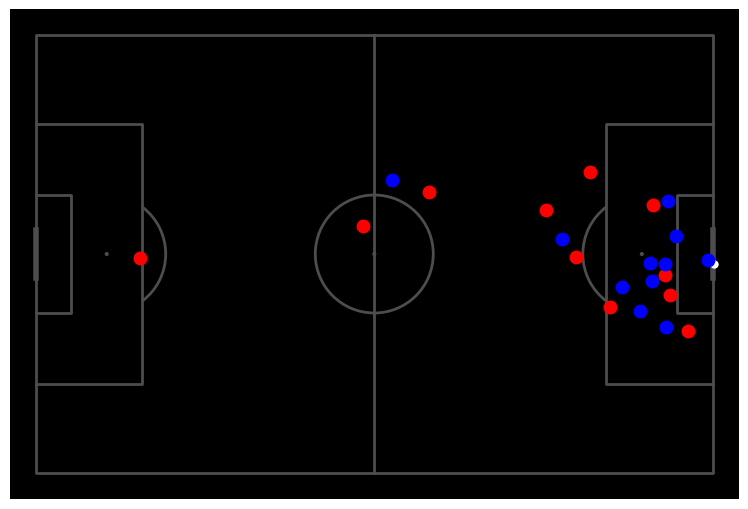

In [6]:
from IPython.display import Video

save_path = 'highest_xg.mp4'
codf_list_sort[0].visualize_frames(save_path)
Video(save_path)

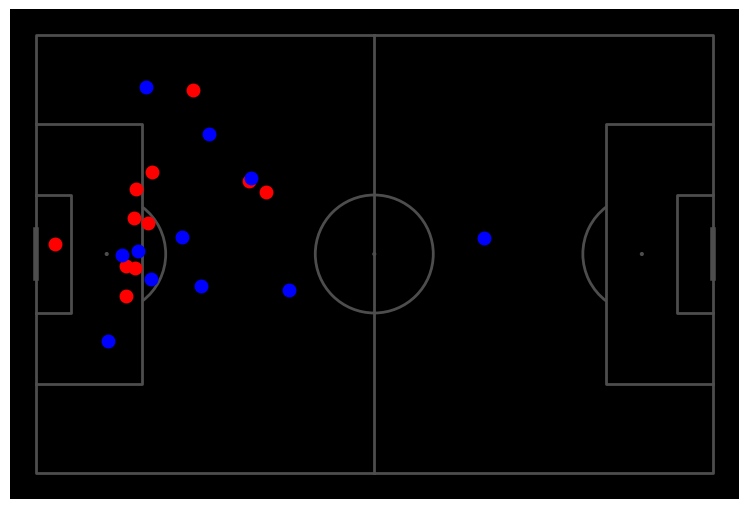

In [7]:
save_path = 'lowest_xg0.mp4'
codf_list_sort[-1].visualize_frames(save_path)
Video(save_path)